# [Chefkoch.de](http://www.chefkoch.de/) Maturaarbeit 2017/18
------

# Convolutional Neural Network

## Ziel: 
### Training vom ersten Model mit [Cloud Computing Power](https://neptune.ml/)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip -q install vit_pytorch linformer

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torch.utils.data as data
from torchvision import transforms, models

%matplotlib inline

import os
from os import walk
from os import listdir
from os.path import isfile, join

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import pathlib
from vit_pytorch.efficient import ViT
import random
from linformer import Linformer
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm




In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [ ]:
# root_dir = '/content/drive/MyDrive/Food-Recipe-CNN/input/images/images'
# ingore_files = ['.DS_Store', 'neptune.log']

# sorted_food_dirs = [fd for fd in sorted(os.listdir(root_dir)) if not fd in ingore_files]

# for i in range(len(sorted_food_dirs)):
#     path = os.path.join(root_dir, sorted_food_dirs[i])
#     for i, filename in enumerate(os.listdir(path)):
#         src = f"{path}/{filename}"
#         name = filename.split('.')[0] + ".jpeg"
#         dst = f"{path}/{name}"
#         os.rename(src, dst)

In [ ]:

data_dir = pathlib.Path("/content/drive/MyDrive/Food-Recipe-CNN/input/images/images")

image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

8439


In [ ]:
train_size = int(image_count*0.7)
val_size = image_count - train_size
batch_size = 32
epochs = 10
lr = 3e-5
gamma = 0.7
seed = 42

print(train_size)


5907


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [ ]:
transform = transforms.Compose([transforms.Resize(224),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


dataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Food-Recipe-CNN/input/images/images', transform=transform)
train, val= data.random_split(dataset, [train_size, val_size])

train_loader = data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = data.DataLoader(val, batch_size=batch_size, shuffle=True)

In [ ]:
class_names = dataset.classes
print(len(class_names))

20


In [ ]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [ ]:

model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=20,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
train_accuracy, val_accuracy = [], []
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
        train_accuracy.append(epoch_accuracy)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
            val_accuracy.append(epoch_val_accuracy)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/185 [00:00<?, ?it/s]

Epoch : 1 - loss : 2.4646 - acc: 0.2369 - val_loss : 2.4785 - val_acc: 0.2246



  0%|          | 0/185 [00:00<?, ?it/s]

Epoch : 2 - loss : 2.4379 - acc: 0.2488 - val_loss : 2.4745 - val_acc: 0.2211



  0%|          | 0/185 [00:00<?, ?it/s]

Epoch : 3 - loss : 2.3973 - acc: 0.2542 - val_loss : 2.4722 - val_acc: 0.2270



  0%|          | 0/185 [00:00<?, ?it/s]

Epoch : 4 - loss : 2.3482 - acc: 0.2650 - val_loss : 2.4987 - val_acc: 0.2074



  0%|          | 0/185 [00:00<?, ?it/s]

Epoch : 5 - loss : 2.2883 - acc: 0.2870 - val_loss : 2.4582 - val_acc: 0.2328



  0%|          | 0/185 [00:00<?, ?it/s]

Epoch : 6 - loss : 2.2031 - acc: 0.3169 - val_loss : 2.5396 - val_acc: 0.2086



  0%|          | 0/185 [00:00<?, ?it/s]

Epoch : 7 - loss : 2.1363 - acc: 0.3368 - val_loss : 2.5453 - val_acc: 0.2109



  0%|          | 0/185 [00:00<?, ?it/s]

Epoch : 8 - loss : 2.0369 - acc: 0.3713 - val_loss : 2.6034 - val_acc: 0.2098



  0%|          | 0/185 [00:00<?, ?it/s]

Epoch : 9 - loss : 1.9170 - acc: 0.4082 - val_loss : 2.6302 - val_acc: 0.2172



  0%|          | 0/185 [00:00<?, ?it/s]

Epoch : 10 - loss : 1.8238 - acc: 0.4476 - val_loss : 2.6537 - val_acc: 0.2215



  0%|          | 0/185 [00:00<?, ?it/s]

Epoch : 11 - loss : 1.6902 - acc: 0.4867 - val_loss : 2.7589 - val_acc: 0.2008



  0%|          | 0/185 [00:00<?, ?it/s]

Epoch : 12 - loss : 1.5653 - acc: 0.5307 - val_loss : 2.8280 - val_acc: 0.2008



  0%|          | 0/185 [00:00<?, ?it/s]

Epoch : 13 - loss : 1.4150 - acc: 0.5798 - val_loss : 2.9461 - val_acc: 0.1871



  0%|          | 0/185 [00:00<?, ?it/s]

Epoch : 14 - loss : 1.2807 - acc: 0.6329 - val_loss : 3.0250 - val_acc: 0.1953



  0%|          | 0/185 [00:00<?, ?it/s]

Epoch : 15 - loss : 1.1389 - acc: 0.6828 - val_loss : 3.0685 - val_acc: 0.2020



  0%|          | 0/185 [00:00<?, ?it/s]

Epoch : 16 - loss : 1.0024 - acc: 0.7322 - val_loss : 3.2101 - val_acc: 0.1898



  0%|          | 0/185 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.8780 - acc: 0.7687 - val_loss : 3.3005 - val_acc: 0.1848



  0%|          | 0/185 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.7485 - acc: 0.8148 - val_loss : 3.4278 - val_acc: 0.1758



  0%|          | 0/185 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.6342 - acc: 0.8506 - val_loss : 3.5005 - val_acc: 0.1816



  0%|          | 0/185 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.5167 - acc: 0.8927 - val_loss : 3.6691 - val_acc: 0.1734



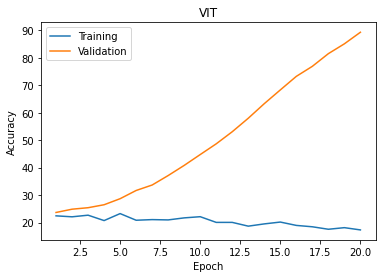

In [ ]:
acc_ls = [0.2246, 0.2211, 0.2270, 0.2074, 0.2328, 0.2086, 0.2109, 0.2098, 0.2172, 0.2215, 0.2008, 0.2008, 0.1871, 0.1953, 0.2020, 0.1898, 0.1848, 0.1758, 0.1816, 0.1734]
val_ls = [0.2369, 0.2488, 0.2542, 0.2650, 0.2870, 0.3169, 0.3368, 0.3713, 0.4082, 0.4476, 0.4867, 0.5307, 0.5798, 0.6329, 0.6828, 0.7322, 0.7687, 0.8148, 0.8506, 0.8927]

acc_ls_per = np.array(acc_ls)*100
val_ls_per = np.array(val_ls)*100
epoch = np.arange(1,21)
plt.title("VIT")
plt.plot(epoch, acc_ls_per, label="Training")
plt.plot(epoch, val_ls_per, label="Validation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
print(train_accuracy)

[tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.2369, device='cuda:0'), tensor(0.

In [ ]:
torch.save(vgg16.state_dict(),'/content/drive/MyDrive/Food-Recipe-CNN/output/models/vgg16_opt_v3.pt')